## 05-direct-vs-indirect-themes

**Purpose**: Compare the themes for articles which were directly shared vs. articles which were indirectly shared by outlet (Newsmax, Breitbart).
- Considered analyzing by content by:
    - Media Cloud `themes` field: only 18% of stories have non-blank values -> no
    - Topic modeling: scraping failure rate too high for some outlets' direct shares (e.g., Newsmax) -> no
    - Media Cloud `url` and `title` fields: all stories have non-blank values -> yes, compare token frequencies using [Shifterator](https://shifterator.readthedocs.io/en/latest/installation.html)
        - `direct`: `title` is available only if a match exists between the `tweets2_url` and the Media Cloud dataset -> availability more limited than expected -> fallback option is to pull tokens from `URL`.
        - `indirect`: `title` is available for all indirect shares (by definition, a corresponding Media Cloud document has already been found) -> use `title` field for tokens.
    ```
    Gallagher, Ryan. J., Morgan R. Frank, Lewis Mitchell, Aaron J. Schwartz, Andrew J. Reagan, Christopher M. Danforth, and Peter Sheridan Dodds. “Generalized Word Shift Graphs: A Method for Visualizing and Explaining Pairwise Comparisons Between Texts.”” EPJ Data Science 10, no. 4 (2021).
    ```

In [1]:
import os
import pandas as pd
import copy
import urlexpander
import shifterator as sh
from collections import Counter
from usrightmedia.shared.loggers import get_logger
LOGGER = get_logger(filename = '05-direct-vs-indirect-themes', logger_type='main')

In [2]:
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))

In [3]:
urls_dir = os.path.join("..", "..", "data", "03-analysis")

In [4]:
# https://github.com/tqdm/tqdm/issues/619#issuecomment-425234504
import tqdm

def nop(it, *a, **k):
    return it

tqdm.tqdm = nop

In [5]:
from inca import Inca
myinca = Inca()
myinca.database.list_doctypes()

2022-12-21 09:04:23,712 - [WARNING] - INCA - (hype_analysis.py).<module>(21) - $DISPLAY environment variable is not set, trying a different approach. You probably are running INCA on a text console, right?
2022-12-21 09:04:23,820 - [WARNING] - INCA - (var_tsa_analysis.py).<module>(21) - $DISPLAY environment variable is not set, trying a different approach. You probably are running INCA on a text console, right?


{'tweets2': 889739,
 'tweets2_url': 285447,
 'foxnews': 264620,
 'breitbart': 149241,
 'dailycaller': 121822,
 'oneamericanews': 117287,
 'washingtonexaminer': 71710,
 'newsmax': 71146,
 'gatewaypundit': 39401,
 'infowars': 28453,
 'vdare': 19643,
 'dailystormer': 15823,
 'americanrenaissance': 9838,
 'rushlimbaugh': 9396,
 'seanhannity': 5647}

In [6]:
outlet_doctypes = [
    "americanrenaissance",
    "breitbart",
    "dailycaller",
    "dailystormer",
    "foxnews",
    "gatewaypundit",
    "infowars",
    "newsmax",
    "oneamericanews",
    "rushlimbaugh",
    "seanhannity",
    "vdare",
    "washingtonexaminer",
]

## Direct shares
- Query Elasticsearch for news articles which were (re-)tweeted at least once (`tweets2_url_match_ind`). Retrieve the `themes` field which was assigned by [Media Cloud's theme classifer](https://mediacloud.org/support/theme-list).
    - "We run all our English stories through a set of trained models to detect what theme(s) they focus on. To build these models, we took the approach of transfer learning - starting with the Google News word2vec models and then adapting them to produce based on the New York Times annotated corpus. We score each story against the most common 600 descriptors from the NYT corpus. Any descriptors that score above 0.2 probability are listed as theme(s) for the story."
- Check how many news articles were assigned 1+ themes.

In [7]:
def _get_direct_shares(doctype):
    """Retrieve the IDs of ES documents which were (re-)tweeted at least once.
        These matches were based on matching 'standardized_url' (a post-scraping field).
    """
    
    query = {
            "query": {
                "bool": {
                  "filter": [
                    {
                      "term": {
                        "tweets2_url_match_ind": "true"
                      }
                    },
                    {
                      "term": {
                        "doctype": doctype                                                       
                      }
                    }
                  ]
                }
              }
            }
    
    docs = [doc["_source"] for doc in myinca.database.document_generator(query)]
    filtered_docs = []
    for d in docs:
        filtered_docs.append({k: v for k, v in d.items() if k !="META"})
    return filtered_docs

In [8]:
def get_direct_themes(doctype):
    docs = _get_direct_shares(doctype)
    doc_themes = [d['themes'] for d in docs]
    doc_themes = [t for t in doc_themes if t !=""]
    try:
        print(f"{doctype=}: {len(doc_themes)} (re-)tweeted articles with non-blank theme field out of {len(docs)} ({round(len(doc_themes)/len(docs)*100, 2)}%)")
    except ZeroDivisionError as e:
        print(f"{doctype=}: No matches for direct shares")
    doc_themes = [t.split(",") for t in doc_themes]
    LOGGER.debug(f"Convert stringified list of themes: {doc_themes[0:2]}")
    themes = [t for ts in doc_themes for t in ts]
    LOGGER.debug(f"Flatten themes from all docs together. First 20 theme assignments: {themes[0:20]}")
    return(Counter(themes))

In [9]:
df_direct_urls = pd.read_pickle(os.path.join(urls_dir, "direct_shared_domains.pkl"))
# only analyze direct (re-)tweets for URLs from selected right-wing media outlets
df_direct_urls = df_direct_urls.loc[df_direct_urls['outlet_std'].isin(outlet_doctypes)]

In [10]:
outlet_themes = {}
for doctype in outlet_doctypes:
    outlet_themes[doctype] = get_direct_themes(doctype)

doctype='americanrenaissance': No matches for direct shares
doctype='breitbart': 128 (re-)tweeted articles with non-blank theme field out of 710 (18.03%)
doctype='dailycaller': 149 (re-)tweeted articles with non-blank theme field out of 830 (17.95%)
doctype='dailystormer': No matches for direct shares
doctype='foxnews': 1113 (re-)tweeted articles with non-blank theme field out of 6215 (17.91%)
doctype='gatewaypundit': 1 (re-)tweeted articles with non-blank theme field out of 12 (8.33%)
doctype='infowars': No matches for direct shares
doctype='newsmax': No matches for direct shares
doctype='oneamericanews': 0 (re-)tweeted articles with non-blank theme field out of 2 (0.0%)
doctype='rushlimbaugh': 1 (re-)tweeted articles with non-blank theme field out of 2 (50.0%)
doctype='seanhannity': 92 (re-)tweeted articles with non-blank theme field out of 454 (20.26%)
doctype='vdare': No matches for direct shares
doctype='washingtonexaminer': 185 (re-)tweeted articles with non-blank theme field out

In [11]:
breitbart_direct_themes = get_direct_themes("breitbart")
breitbart_direct_themes.most_common()[0:10]

doctype='breitbart': 128 (re-)tweeted articles with non-blank theme field out of 710 (18.03%)


[('politics and government', 91),
 ('united states politics and government', 60),
 ('finances', 31),
 ('immigration and refugees', 26),
 ('law and legislation', 25),
 ('crime and criminals', 19),
 ('medicine and health', 18),
 ('international relations', 18),
 ('elections', 16),
 ('armament', 15)]

In [12]:
newsmax_direct_themes = get_direct_themes("newsmax")
display(newsmax_direct_themes.most_common()[0:10])

doctype='newsmax': No matches for direct shares


[]

### Issue with limited availability of assigned `themes` by Media Cloud
- 18% of Media Cloud stories have non-empty `themes` field values.
- An alternative which was considered is to conduct topic modeling on the scraped articles and then to analyze the (in)direct shares through those topic assignments. However, the (re-)tweeted article URLs (as illustrated by `get_direct_themes()`) show that failed scraping attempts are an issue (e.g., for Newsmax). Given this limitation, Media Cloud's `themes` field provides the best option for thematic analysis (with recognition that not all stories are labeled).

```
GET /inca_alias/_count
{
  "query": {
    "bool": {
      "filter": [
        {
          "terms": {
            "doctype": [
              "americanrenaissance",
              "breitbart",
              "dailycaller",
              "dailystormer",
              "foxnews",
              "gatewaypundit",
              "infowars",
              "newsmax",
              "oneamericanews",
              "rushlimbaugh",
              "seanhannity",
              "vdare",
              "washingtonexaminer"
            ]
          }
        },
        {
          "bool": {
            "must_not": {
              "term": {
                "themes.keyword": ""
              }
            }
          }
        }
      ]
    }
  }
}

RETURNS:
{
  "count" : 172497,
  "_shards" : {
    "total" : 5,
    "successful" : 5,
    "skipped" : 0,
    "failed" : 0
  }
}
```

```
GET /inca_alias/_count
{
  "query": {
    "bool": {
      "filter": [
        {
          "terms": {
            "doctype": [
              "americanrenaissance",
              "breitbart",
              "dailycaller",
              "dailystormer",
              "foxnews",
              "gatewaypundit",
              "infowars",
              "newsmax",
              "oneamericanews",
              "rushlimbaugh",
              "seanhannity",
              "vdare",
              "washingtonexaminer"
            ]
          }
        },
        {
          "bool": {
            "must": {
              "term": {
                "themes.keyword": ""
              }
            }
          }
        }
      ]
    }
  }
}

RETURNS:
{
  "count" : 751530,
  "_shards" : {
    "total" : 5,
    "successful" : 5,
    "skipped" : 0,
    "failed" : 0
  }
}
```

In [13]:
f"{round(172497/(172497+751530)*100, 1)}% of Media Cloud stories have a non-empty 'themes' field."

"18.7% of Media Cloud stories have a non-empty 'themes' field."

### Issue with matching on `standardized_url`
- The original matching between the (re-)tweets and articles was based on the `standardized_url` field. This would provide the best attempt at comprehensive data analysis, since successful matches would be based on the actual HTTP request URL and would more likely be accompanied by scraped article text (`standardized_url` on outlet doctypes is based on the URL returned from an actual request through urlExpander; no match would happen if urlExpander had returned a `CONNECTIONPOOL_ERROR` or `CLIENT_ERROR`.).
- Unfortunately, matching based on this 'ideal' case ends up with some outlets' direct shares (e.g., Newsmax) all failing to scrape and returning no results for the themes analysis when using `tweets2_url_match_ind`.
- An alternative option (which makes the dataset selection differ per analysis), is to:
    - Query for `doctype=tweets2_url` using the `url_id`. This will provide access to the multiple URL variants associated with a particular (re-)tweeted URL.
    - Use the URL variants to search for matches against `url` in the Media Cloud documents.
        - Option 1.1: Analyze the `themes` field. Per above, only 18% of Media Cloud stories are assigned non-blank `themes`.
        - Option 1.2: Analyze the `title` field. This is available for all Media Cloud stories but there must be a URL match between the (re-)tweet object and the Media Cloud object.
        - Option 1.3: Analyze the `most_unrolled_url` field from the (re-)tweet object. Parse out keywords directly from the URL. This does not require any URL matching across (re-)tweet and Media Cloud objects.

In [14]:
df_direct_urls[df_direct_urls["outlet_std"]=="newsmax"].groupby("urlexpander_error").size()

urlexpander_error
CONNECTIONPOOL_ERROR    144
dtype: int64

In [15]:
df_direct_urls.groupby(['urlexpander_error']).size()

urlexpander_error
CLIENT_ERROR              166
CONNECTIONPOOL_ERROR      150
no error                13645
dtype: int64

In [16]:
df_direct_urls[df_direct_urls["outlet_std"]=="newsmax"].head()

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,pew_libdem,pew_consrep,pew_libdem_consrep_diff,ideo_category,ideo_subcategory,ideo_left2right
34384,1327302507857666051_0,2020-11-13 17:29:12,2020-01-01,RepDougCollins,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,NaN,NaN,-999.0,right,alternative right,30.0
34385,1285957709402124296_0,2020-07-22 15:19:44,2020-01-01,SenTedCruz,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,NaN,NaN,-999.0,right,alternative right,30.0
34386,1263884642639208448_0,2020-05-22 17:29:15,2020-01-01,SenTedCruz,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,NaN,NaN,-999.0,right,alternative right,30.0
34387,697264426911576066_0,2016-02-10 03:42:48,2016-01-01,RepKevinBrady,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,NaN,NaN,-999.0,right,alternative right,30.0
34388,1253833735616835584_1,2020-04-24 23:50:32,2020-01-01,SenTedCruz,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,NaN,NaN,-999.0,right,alternative right,30.0


In [17]:
def get_url_variants(url_ids):
    """
    Get the URL variations associated with a list of url_ids (doctype: tweets2_url).
    The original (re-)tweet to Media Cloud matching was done based on 'standardized_url'.
    This field relies on post-scraping results and a thematic analysis is not possible for some outlets as the attempts to scrape their directly shared URLs failed.
    This is represented in 'standardized_url' with "CONNECTIONPOOL_ERROR" or "CLIENT_ERROR",
    which meant that the subsequent attempts to match such a tweets2_url url_id to a Media Cloud story ES document would be guaranteed to fail.
    
    The backup option is to try using alternative URLs to match into the Media Cloud stories.
    If a match is found, the 'themes' field can be analyzed. 18% of Media Cloud stories have non-blank 'themes' fields
    so note that any thematic patterns of what is directly/indirectly shared is based on only a subset of stories labeled by Media Cloud.
    """
    query = {
            "query": {
                "bool": {
                  "filter": [
                    {
                      "terms": {
                        "url_id": url_ids
                      }
                    },
                    {
                      "term": {
                        "doctype": "tweets2_url"
                      }
                    }
                  ]
                }
              }
            }
    
    docs = [d["_source"] for d in myinca.database.document_generator(query)]
    docs = [{k: v for k, v in d.items() if k !="META"} for d in docs]
    df_docs = pd.DataFrame(docs)
    df_docs = df_docs[['doctype', 'url_id', 'expanded_url', 'display_url',
                       'unwound_url', 'most_unrolled_url', 'most_unrolled_field',
                       'resolved_url', 'selected_url', 
                       'standardized_netloc', 'standardized_domain',
                       'standardized_url_is_generic']]
    return df_docs

In [18]:
# Don't use 'standardized_url' as it is a post-scraping field.
# We want to use a pre-scraping field (i.e., match between Media Cloud-provided URL and Twitter-provided URL).
# This is a back-up option since 'standardized_url' shows "CLIENT_ERROR" or "CONNECTIONPOOL_ERROR" when the scrape fails -> fails to match with tweets2_url.
df_direct_url_variants = get_url_variants(list(df_direct_urls['url_id']))

In [19]:
dfm_direct_urls = df_direct_urls.merge(right=df_direct_url_variants,
                                       on='url_id',
                                       validate='one_to_one')

In [20]:
dfm_direct_urls

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,...,expanded_url,display_url,unwound_url,most_unrolled_url,most_unrolled_field,resolved_url,selected_url,standardized_netloc,standardized_domain,standardized_url_is_generic
0,1016809976789159937_0,2018-07-10 22:22:44,2018-01-01,KenCalvert,www.washingtonexaminer.com/policy/economy/hire...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,https://goo.gl/7JtkE6,goo.gl/7JtkE6,None,https://goo.gl/7JtkE6,expanded_url,https://www.washingtonexaminer.com/policy/econ...,https://www.washingtonexaminer.com/policy/econ...,www.washingtonexaminer.com,washingtonexaminer.com,False
1,706936239220330498_0,2016-03-07 20:15:08,2016-01-01,KenCalvert,www.washingtonexaminer.com/how-a-new-bill-to-f...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,http://goo.gl/gIRHEU,goo.gl/gIRHEU,None,http://goo.gl/gIRHEU,expanded_url,https://www.washingtonexaminer.com/how-a-new-b...,https://www.washingtonexaminer.com/how-a-new-b...,www.washingtonexaminer.com,washingtonexaminer.com,False
2,735190770035138560_0,2016-05-24 19:28:33,2016-01-01,RepComstock,www.washingtonexaminer.com/lawmaker-let-privat...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,http://www.washingtonexaminer.com/lawmaker-let...,washingtonexaminer.com/lawmaker-let-p…,None,http://www.washingtonexaminer.com/lawmaker-let...,expanded_url,https://www.washingtonexaminer.com/lawmaker-le...,https://www.washingtonexaminer.com/lawmaker-le...,www.washingtonexaminer.com,washingtonexaminer.com,False
3,971799132707926016_0,2018-03-08 17:25:43,2018-01-01,RepByrne,www.washingtonexaminer.com/how-to-end-governme...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,http://www.washingtonexaminer.com/how-to-end-g...,washingtonexaminer.com/how-to-end-gov…,None,http://www.washingtonexaminer.com/how-to-end-g...,expanded_url,https://www.washingtonexaminer.com/how-to-end-...,https://www.washingtonexaminer.com/how-to-end-...,www.washingtonexaminer.com,washingtonexaminer.com,False
4,1204042988285919233_0,2019-12-09 14:19:53,2019-01-01,RepChrisStewart,www.washingtonexaminer.com/opinion/utah-republ...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,https://www.washingtonexaminer.com/opinion/uta...,washingtonexaminer.com/opinion/utah-r…,None,https://www.washingtonexaminer.com/opinion/uta...,expanded_url,https://www.washingtonexaminer.com/opinion/uta...,https://www.washingtonexaminer.com/opinion/uta...,www.washingtonexaminer.com,washingtonexaminer.com,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13956,1007700713038929920_0,2018-06-15 19:05:46,2018-01-01,CongHuelskamp,www.amren.com/news/2018/06/jared-taylor-wins-f...,amren.com,no error,American Renaissance,americanrenaissance,True,...,https://bit.ly/2JHZVRp,bit.ly/2JHZVRp,None,https://bit.ly/2JHZVRp,expanded_url,https://www.amren.com/news/2018/06/jared-taylo...,https://www.amren.com/news/2018/06/jared-taylo...,www.amren.com,amren.com,False
13957,698160432549384192_0,2016-02-12 15:03:12,2016-01-01,RepCurtClawson,925foxnews.com/__client_error__,925foxnews.com,CLIENT_ERROR,Fox News,foxnews,True,...,http://925foxnews.com/mp3/DB_Guest_-_Curt_Claw...,925foxnews.com/mp3/DB_Guest_-…,None,http://925foxnews.com/mp3/DB_Guest_-_Curt_Claw...,expanded_url,http://925foxnews.com/__CLIENT_ERROR__,http://925foxnews.com/mp3/DB_Guest_-_Curt_Claw...,925foxnews.com,925foxnews.com,False
13958,690555484961529856_0,2016-01-22 15:23:52,2016-01-01,RepCurtClawson,925foxnews.com/__client_error__,925foxnews.com,CLIENT_ERROR,Fox News,foxnews,True,...,http://925foxnews.com/mp3/DB_Guest_-_Curt_Claw...,925foxnews.com/mp3/DB_Guest_-…,None,http://925foxnews.com/mp3/DB_Guest_-_Curt_Claw...,expanded_url,http://925foxnews.com/__CLIENT_ERROR__,http://925foxnews.com/mp3/DB_Guest_-_Curt_Claw...

In [21]:
def match_mc_docs(url_variants, doctype):
    """Query ES for 0+ matches among Media cloud stories using the standardized version of the 'most_unrolled_url' from a tweet2_url document.
    
    Args: 
        url_variants (list of str)
        doctype (str)
        
    Returns:
        mc_ids (list): 0+ document IDs associated with Media Cloud stories
        mc_titles (list): 0+ titles associated with Media Cloud stories
        mc_themes (list): 0+ themes associated with Media Cloud stories
        
    
    """
    # filter out non-string values since these aren't URLs (e.g., None)
    url_variants = [x for x in url_variants if isinstance(x, str)]

    query = {
            "query": {
                "bool": {
                  "filter": [
                    {
                      "terms": {
                        "url": url_variants
                      }
                    },
                    {
                      "term": {
                        "doctype": doctype
                      }
                    }
                  ]
                }
              }
            }
    docs = [doc for doc in myinca.database.document_generator(query)]
    mc_ids = [doc["_id"] for doc in docs]
    mc_titles = [doc['_source']["title"] for doc in docs]
    mc_themes = [doc['_source']["themes"] for doc in docs]
    return pd.Series([mc_ids, mc_titles, mc_themes])

In [22]:
dfm_direct_urls.columns

Index(['url_id', 'created_at', 'created_at_year', 'username',
       'standardized_url', 'url_netloc', 'urlexpander_error', 'outlet',
       'outlet_std', 'is_selected_outlet', 'pew_libdem', 'pew_consrep',
       'pew_libdem_consrep_diff', 'ideo_category', 'ideo_subcategory',
       'ideo_left2right', 'doctype', 'expanded_url', 'display_url',
       'unwound_url', 'most_unrolled_url', 'most_unrolled_field',
       'resolved_url', 'selected_url', 'standardized_netloc',
       'standardized_domain', 'standardized_url_is_generic'],
      dtype='object')

In [23]:
%%time
# https://stackoverflow.com/a/53666187/7016397
dfm_direct_urls[['mc_ids', 'mc_titles', 'mc_themes']] = dfm_direct_urls\
                                                            .apply(lambda r: match_mc_docs(url_variants = [r['expanded_url'], r['display_url'], r['unwound_url'],
                                                                                                           r['most_unrolled_url'], r['resolved_url'],
                                                                                                           r['selected_url'], r['standardized_url']],
                                                                                           doctype = r['outlet_std']),axis=1)

CPU times: user 53.6 s, sys: 3.99 s, total: 57.6 s
Wall time: 2min 16s


In [24]:
# empty list is Falsey
dfm_direct_urls_titles = dfm_direct_urls[dfm_direct_urls["mc_ids"].astype(bool)].reset_index(drop=True)
dfm_direct_urls_titles

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,...,most_unrolled_url,most_unrolled_field,resolved_url,selected_url,standardized_netloc,standardized_domain,standardized_url_is_generic,mc_ids,mc_titles,mc_themes
0,1151962519122141197_0,2019-07-18 21:10:41,2019-01-01,SenTedCruz,www.washingtonexaminer.com/policy/healthcare/t...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,https://washex.am/2M0zq9N,expanded_url,https://www.washingtonexaminer.com/policy/heal...,https://www.washingtonexaminer.com/policy/heal...,www.washingtonexaminer.com,washingtonexaminer.com,False,[WashingtonExaminer_1356423597],[Ted Cruz bill would speed FDA approval of dru...,"[politics and government,law and legislation,m..."
1,971789704214454272_0,2018-03-08 16:48:15,2018-01-01,JohnCornyn,www.washingtonexaminer.com/no-stock-buybacks-d...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,http://www.washingtonexaminer.com/article/2650807,expanded_url,https://www.washingtonexaminer.com/no-stock-bu...,https://www.washingtonexaminer.com/no-stock-bu...,www.washingtonexaminer.com,washingtonexaminer.com,False,[WashingtonExaminer_1036931869],"[No, stock buybacks don't discredit tax cuts]",[]
2,837727001708486656_0,2017-03-03 18:10:56,2017-01-01,SenatorLankford,www.washingtonexaminer.com/total-federal-debt-...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,https://www.washingtonexaminer.com/total-feder...,unwound_url,https://www.washingtonexaminer.com/total-feder...,https://www.washingtonexaminer.com/total-feder...,www.washingtonexaminer.com,washingtonexaminer.com,False,"[WashingtonExaminer_803716815, WashingtonExami...","[Total federal debt set to pass $20 trillion, ...","[, finances]"
3,734825248445607938_0,2016-05-23 19:16:06,2016-01-01,RodneyDavis,www.washingtonexaminer.com/va-secretary-disney...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,http://www.washingtonexaminer.com/va-secretary...,expanded_url,https://www.washingtonexaminer.com/va-secretar...,https://www.washingtonexaminer.com/va-secretar...,www.washingtonexaminer.com,washingtonexaminer.com,False,[WashingtonExaminer_512492400],[VA secretary: Disney doesn't measure wait tim...,[medicine and health]
4,891125769006612481_0,2017-07-29 02:38:34,2017-01-01,RepRibble,www.washingtonexaminer.com/tag/donald-trump,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,https://www.washingtonexaminer.com/tag/donald-...,unwound_url,https://www.washingtonexaminer.com/tag/donald-...,https://www.washingtonexaminer.com/tag/donald-...,www.washingtonexaminer.com,washingtonexaminer.com,False,[WashingtonExaminer_665575723],[Trump family became increasingly disappointed...,[quotation of the day]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5031,1030689370838319104_0,2018-08-18 05:34:29,2018-01-01,RepMattGaetz,www.thegatewaypundit.com/2018/08/rep-gaetz-ros...,thegatewaypundit.com,no error,The Gateway Pundit,gatewaypundit,True,...,https://www.thegatewaypundit.com/2018/08/rep-g...,expanded_url,https://www.thegatewaypundit.com/2018/08/rep-g...,https://www.thegatewaypundit.com/2018/08/rep-g...,www.thegatewaypundit.com,thegatewaypundit.com,False,[GatewayPundit_957424726],[Rep. Gaetz: Rosenstein Won&#8217;t Tell Us Wh...,[]
5032,1100870389402660871_0,2019-02-27 21:28:48,2019-01-01,RepMarkGreen,www.rushlimbaugh.com/daily/2019/02/27/congress...,rushlimbaugh.com,no error,Rush Limbaugh,rushlimbaugh,True,...,https://www.rushlimbaugh.com/daily/2019/02/27/...,expanded_url,https://www.rushlimbaugh.com/daily/2019/02/27/...,https://www.rushlimbaugh.com/daily/2019/02/27/...,www.rushlimbaugh.com,rushlimbaugh.com,False,[RushLimbaugh_1211018924],[Congressman Green Puts the Cohen Circus in Pe...,[]
5033,1321564370476912641_0,2020-10-28 21:27:54,2020-01-01,SenTedCruz,www.rushli

In [25]:
def prep_mc_title_tokens(titles):
    """Prep list of returned Media Cloud titles.
    1. keep unique titles (remove duplicates)
    2. concatenate remaining titles
    3. split on spaces
    4. lower-case
    5. keep alphabetic words (note this removes contractions)
    6. remove stopwords
    """
    tokens = ' '.join(list(set(titles))).split(' ')
    tokens = [t.lower() for t in tokens]
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stops]
    tokens = [t for t in tokens if t != 'u']
    return tokens

In [26]:
dfm_direct_urls_titles['mc_titles_tokens'] = dfm_direct_urls_titles['mc_titles'].map(lambda x: prep_mc_title_tokens(x))

- The `titles` option won't work for Newsmax because there are too few Media Cloud matches despite attempting to find a match through the URL variants.

In [27]:
dfm_direct_urls_titles.loc[dfm_direct_urls_titles['outlet_std']=='newsmax']

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,...,most_unrolled_field,resolved_url,selected_url,standardized_netloc,standardized_domain,standardized_url_is_generic,mc_ids,mc_titles,mc_themes,mc_titles_tokens
4983,1002287404454174721_0,2018-05-31 20:35:13,2018-01-01,SenTedCruz,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,...,expanded_url,http://www.newsmax.com/__CONNECTIONPOOL_ERROR__,https://www.newsmax.com/henryfcooper/trump-cru...,www.newsmax.com,newsmax.com,False,[Newsmax_1001258467],[Trump Must Support Sen. Cruz on Space-Based M...,"[politics and government,armament, defense and...","[trump, must, support, cruz, missile, defense]"
4984,1341900371158065152_0,2020-12-24 00:15:54,2020-01-01,RepDLesko,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,...,expanded_url,http://www.newsmax.com/__CONNECTIONPOOL_ERROR__,https://www.newsmax.com/politics/constitution-...,www.newsmax.com,newsmax.com,False,[Newsmax_1843859494],[Did 2020 Presidential Election in Four States...,[],"[presidential, election, four, states, follow,..."
4985,1215020955925438465_0,2020-01-08 21:22:24,2020-01-01,RepJimBanks,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,...,expanded_url,http://www.newsmax.com/__CONNECTIONPOOL_ERROR__,https://www.newsmax.com/politics/jim-banks-ira...,www.newsmax.com,newsmax.com,False,[Newsmax_1568420657],[Rep. Banks: Trump's Iran Strategy Is Working ...,[],"[iran, strategy, working]"
4986,996808829672345606_0,2018-05-16 17:45:19,2018-01-01,DesJarlaisTN04,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,...,unwound_url,http://www.newsmax.com/__CONNECTIONPOOL_ERROR__,https://www.newsmax.com/newsfront/grenell-germ...,www.newsmax.com,newsmax.com,False,[Newsmax_983578782],[German Firms Heed Trump on Iran as Ambassador...,"[politics and government,united states politic...","[german, firms, heed, trump, iran, ambassador,..."
4987,1339237743352815616_0,2020-12-16 15:55:34,2020-01-01,RepDougCollins,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,...,expanded_url,http://www.newsmax.com/__CONNECTIONPOOL_ERROR__,https://www.newsmax.com/politics/bill-barr-jef...,www.newsmax.com,newsmax.com,False,[Newsmax_1834709283],[Trump Asking About Special Prosecutor for Hun...,[],"[trump, asking, special, prosecutor, hunter, b..."


- Use the `URL` parsing option for Newsmax since every directly (re-)tweeted article comes with a non-blank value for the `most_unrolled_url` field.

In [28]:
def prep_newsmax_url_tokens(url):
    """Prep most_unrolled_url (from Twitter API).
    1. parse out URL components
    3. split on '/'
    4. lower-case
    5. keep alphabetic words (note this removes contractions)
    6. remove stopwords
    
    'https://www.newsmax.com/newsmax-tv/collins-secretary-georgia-2020/2020/11/12/id/996778/' -> ['collins', 'secretary', 'georgia']
    """
    try:
        cleaned_url = urlexpander.url_utils.standardize_url(url=url,
                                                        remove_scheme=True,
                                                        replace_netloc_with_domain=True,
                                                        remove_path=False,
                                                        remove_query=False,
                                                        remove_fragment=True,
                                                        to_lowercase=True)
        tokens = cleaned_url.split('/')[2].split('-')
        tokens = [t.lower() for t in tokens]
        tokens = [t for t in tokens if t.isalpha()]
        tokens = [t for t in tokens if t not in stops]
        tokens = [t for t in tokens if t != 'u']
    except:
        tokens = []
    return tokens

In [29]:
dfm_direct_urls_newsmax = dfm_direct_urls.loc[dfm_direct_urls['outlet_std']=='newsmax'].reset_index(drop=True)
dfm_direct_urls_newsmax['url_tokens'] = dfm_direct_urls_newsmax['most_unrolled_url'].map(lambda x: prep_newsmax_url_tokens(x))
dfm_direct_urls_newsmax

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,...,most_unrolled_field,resolved_url,selected_url,standardized_netloc,standardized_domain,standardized_url_is_generic,mc_ids,mc_titles,mc_themes,url_tokens
0,1327302507857666051_0,2020-11-13 17:29:12,2020-01-01,RepDougCollins,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,...,expanded_url,http://www.newsmax.com/__CONNECTIONPOOL_ERROR__,https://www.newsmax.com/newsmax-tv/collins-sec...,www.newsmax.com,newsmax.com,False,[],[],[],"[collins, secretary, georgia]"
1,1285957709402124296_0,2020-07-22 15:19:44,2020-01-01,SenTedCruz,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,...,expanded_url,http://www.newsmax.com/__CONNECTIONPOOL_ERROR__,https://www.newsmax.com/politics/ted-cruz-riot...,www.newsmax.com,newsmax.com,False,[],[],[],"[ted, cruz, rioters, radicals, local, leaders]"
2,1263884642639208448_0,2020-05-22 17:29:15,2020-01-01,SenTedCruz,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,...,expanded_url,http://www.newsmax.com/__CONNECTIONPOOL_ERROR__,https://www.newsmax.com/politics/propaganda-go...,www.newsmax.com,newsmax.com,False,[],[],[],"[propaganda, government, assistance, senate]"
3,697264426911576066_0,2016-02-10 03:42:48,2016-01-01,RepKevinBrady,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,...,expanded_url,http://www.newsmax.com/__CONNECTIONPOOL_ERROR__,http://www.newsmax.com/Newsfront/Republicans-R...,www.newsmax.com,newsmax.com,False,[],[],[],"[republicans, reject, obama, budget]"
4,1253833735616835584_1,2020-04-24 23:50:32,2020-01-01,SenTedCruz,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,...,expanded_url,http://www.newsmax.com/__CONNECTIONPOOL_ERROR__,https://www.newsmax.com/politics/crus-pelosi-e...,www.newsmax.com,newsmax.com,False,[],[],[],"[crus, pelosi, emergencyreliefpackage]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1294273962923438081_0,2020-08-14 14:05:33,2020-01-01,RepKevinBrady,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,...,expanded_url,http://www.newsmax.com/__CONNECTIONPOOL_ERROR__,https://www.newsmax.com/newsfront/vaccine-Reli...,www.newsmax.com,newsmax.com,False,[],[],[],"[vaccine, reliefbill, kevinbrady]"
140,1263092022723960832_0,2020-05-20 12:59:39,2020-01-01,RepBillJohnson,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,...,expanded_url,http://www.newsmax.com/__CONNECTIONPOOL_ERROR__,https://www.newsmax.com/newsfront/bill-johnson...,www.newsmax.com,newsmax.com,False,[],[],[],"[bill, johnson, impeachment, inquiry, judge]"
141,1338566044688977920_0,2020-12-14 19:26:29,2020-01-01,RandPaul,www.newsmax.com/__connectionpool_error__,newsmax.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,...,expanded_url,http://www.newsmax.com/__CONNECTIONPOOL_ERROR__,https://www.newsmax.com/us/randpaul-economy-co...,www.newsmax.com,newsmax.com,False,[],[],[],"[randpaul, economy, coronavirus]"
142,712428421716938752_0,2016-03-22 23:59:06,2016-01-01,RepPittenger,www.newsmaxtv.com/__connectionpool_error__,newsmaxtv.com,CONNECTIONPOOL_ERROR,Newsmax,newsmax,True,...,expanded_url,http://www.newsmaxtv.com/__CONNECTIONPOOL_ERROR__,http://www.newsmaxtv.com/shows/newsmax-prime/a...,www.newsmaxtv.com,newsmaxtv.com,False,[],[],[],"[newsmax, prime]"


In [30]:
newsmax_tokens_direct_url = list(dfm_direct_urls_newsmax['url_tokens'])
newsmax_tokens_direct_url = [t for l_tokens in newsmax_tokens_direct_url for t in l_tokens if t != 'newsmax']

In [31]:
def prep_breitbart_url_tokens(url):
    """Prep most_unrolled_url (from Twitter API).
    1. parse out URL components
    3. split on '/', keep 6th item
    4. lower-case
    5. keep alphabetic words (note this removes contractions)
    6. remove stopwords
    
    'https://www.breitbart.com/politics/2016/03/21/obama-welcomes-castro-criticism-of-the-united-states/' -> ['obama', 'wecomes', 'castro', ...]
    """
    try:
        if 'www.breitbart.com' in url:
            cleaned_url = urlexpander.url_utils.standardize_url(url=url,
                                                            remove_scheme=True,
                                                            replace_netloc_with_domain=True,
                                                            remove_path=False,
                                                            remove_query=False,
                                                            remove_fragment=True,
                                                            to_lowercase=True)
            tokens = cleaned_url.split('/')[5].split('-')
            tokens = [t.lower() for t in tokens]
            tokens = [t for t in tokens if t.isalpha()]
            tokens = [t for t in tokens if t not in stops]
            tokens = [t for t in tokens if t != 'u']
        else:
            tokens = []
    except IndexError as e:
            tokens = []
    return tokens

- Use the `URL` parsing option for Breitbart since every directly (re-)tweeted article comes with a non-blank value for the `most_unrolled_url` field.

In [32]:
dfm_direct_urls_breitbart = dfm_direct_urls.loc[dfm_direct_urls['outlet_std']=='breitbart'].reset_index(drop=True)
dfm_direct_urls_breitbart['url_tokens'] = dfm_direct_urls_breitbart['most_unrolled_url'].map(lambda x: prep_breitbart_url_tokens(x))
dfm_direct_urls_breitbart

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,...,most_unrolled_field,resolved_url,selected_url,standardized_netloc,standardized_domain,standardized_url_is_generic,mc_ids,mc_titles,mc_themes,url_tokens
0,712285484337262592_0,2016-03-22 14:31:07,2016-01-01,RepFleming,www.breitbart.com/politics/2016/03/21/obama-we...,breitbart.com,no error,Breitbart,breitbart,True,...,unwound_url,https://www.breitbart.com/politics/2016/03/21/...,https://www.breitbart.com/politics/2016/03/21/...,www.breitbart.com,breitbart.com,False,[Breitbart_1486963953],[Obama Welcomes Castro Criticism Of The United...,[],"[obama, welcomes, castro, criticism, united, s..."
1,1119244298992664577_0,2019-04-19 14:20:10,2019-01-01,SenHydeSmith,www.breitbart.com/politics/2019/04/18/attorney...,breitbart.com,no error,Breitbart,breitbart,True,...,expanded_url,https://www.breitbart.com/politics/2019/04/18/...,https://www.breitbart.com/politics/2019/04/18/...,www.breitbart.com,breitbart.com,False,[],[],[],[]
2,732282980132106241_0,2016-05-16 18:54:02,2016-01-01,RepFleming,www.breitbart.com/politics/2016/05/13/report-w...,breitbart.com,no error,Breitbart,breitbart,True,...,expanded_url,https://www.breitbart.com/politics/2016/05/13/...,https://www.breitbart.com/politics/2016/05/13/...,www.breitbart.com,breitbart.com,False,[],[],[],"[report, wendys, roll, self, serve, kiosks, en..."
3,1121776255144275969_0,2019-04-26 14:01:15,2019-01-01,RepMoBrooks,www.breitbart.com/economy/2019/04/26/us-econom...,breitbart.com,no error,Breitbart,breitbart,True,...,expanded_url,https://www.breitbart.com/economy/2019/04/26/u...,https://www.breitbart.com/economy/2019/04/26/u...,www.breitbart.com,breitbart.com,False,[],[],[],[]
4,1295768937414762496_0,2020-08-18 17:06:03,2020-01-01,SenatorLoeffler,www.breitbart.com/politics/2020/08/10/gop-sena...,breitbart.com,no error,Breitbart,breitbart,True,...,unwound_url,https://www.breitbart.com/politics/2020/08/10/...,https://www.breitbart.com/politics/2020/08/10/...,www.breitbart.com,breitbart.com,False,[],[],[],"[gop, senators, press, doj, investigate, plann..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,1288148990433865728_0,2020-07-28 16:27:06,2020-01-01,RepMattGaetz,www.breitbart.com/tech/2020/07/27/rep-matt-gae...,breitbart.com,no error,Breitbart,breitbart,True,...,expanded_url,https://www.breitbart.com/tech/2020/07/27/rep-...,https://www.breitbart.com/tech/2020/07/27/rep-...,www.breitbart.com,breitbart.com,False,[Breitbart_1695607072],[Rep. Matt Gaetz Files Criminal Referral Again...,[],"[rep, matt, gaetz, files, criminal, referral, ..."
985,1071076063806193665_0,2018-12-07 16:16:47,2018-01-01,RepMoBrooks,www.breitbart.com/politics/2018/04/03/nearly-2...,breitbart.com,no error,Breitbart,breitbart,True,...,expanded_url,https://www.breitbart.com/politics/2018/04/03/...,https://www.breitbart.com/politics/2018/04/03/...,www.breitbart.com,breitbart.com,False,[Breitbart_1033683241],[Nearly 2-in-3 Americans Say They Support 2020...,[],"[nearly, americans, say, support, census, aski..."
986,1144331920492388352_0,2019-06-27 19:49:25,2019-01-01,SenTedCruz,www.breitbart.com/politics/2019/06/26/gop-lawm...,breitbart.com,no error,Breitbart,breitbart,True,...,expanded_url,https://www.breitbart.com/politics/2019/06/26/...,https://www.breitbart.com/politics/2019/06/26/...,www.breitbart.com,breitbart.com,False,[],[],[],[]
987,1255289740535922689_0,2020-04-29 00:16:10,2020-01-01,RepGosar,www.breitbart.com/politics/2020/04/28/wapo-pol...,breitbart.com,no error,Breitbart,breitbart,True,...,unwound_url,https://www.breitbart.com/politics/2020/04/28/...,https://www.breitbart.com/politics/2020/04/28/...,www.breitbart.com,breitbart.com,False,[],[],[],"[wapo, poll, percent, americans, want, immigra..."


In [33]:
breitbart_tokens_direct_url = list(dfm_direct_urls_breitbart['url_tokens'])
breitbart_tokens_direct_url = [t for l_tokens in breitbart_tokens_direct_url for t in l_tokens if t != 'breitbart']

## Indirect shares

In [34]:
df_indirect_urls = pd.read_pickle(os.path.join(urls_dir, "indirect_shared_domains_through_dyads.pkl"))

In [35]:
len(df_indirect_urls)

1268

In [36]:
df_indirect_urls.columns

Index(['url_id', 'created_at', 'created_at_year', 'username',
       'standardized_url', 'url_netloc', 'urlexpander_error', 'outlet',
       'outlet_std', 'is_selected_outlet', 'pew_libdem', 'pew_consrep',
       'pew_libdem_consrep_diff', 'ideo_category', 'ideo_subcategory',
       'ideo_left2right', 'cluster_id', 'cluster_size', 'doc_id',
       'doc_publish_date', 'doc_title', 'doctype', 'doctype_ideo', 'doc_topic',
       'd0_doc_id', 'd0_doctype', 'dyad_pos', 'd1_doc_id', 'd1_doctype',
       'd0_outlet', 'd1_outlet'],
      dtype='object')

In [37]:
df_indirect_urls.head()

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,...,doctype,doctype_ideo,doc_topic,d0_doc_id,d0_doctype,dyad_pos,d1_doc_id,d1_doctype,d0_outlet,d1_outlet
0,DesJarlaisTN04_859058573053186048_0,2017-05-01 14:54:59,2017-01-01,DesJarlaisTN04,www.washingtonexaminer.com/trump-signs-executi...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,washingtonexaminer,est,topic1,DailyCaller_615309601,dailycaller,1.0,WashingtonExaminer_822152161,washingtonexaminer,Daily Caller,Washington Examiner
1,SenTedCruz_1153377065275744256_0,2019-07-22 18:51:35,2019-01-01,SenTedCruz,www.washingtonexaminer.com/news/ted-cruz-and-b...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,washingtonexaminer,est,topic2,GatewayPundit_1342539334,gatewaypundit,1.0,WashingtonExaminer_1356440915,washingtonexaminer,The Gateway Pundit,Washington Examiner
2,replouiegohmert_689917877424648192_0,2016-01-20 21:10:14,2016-01-01,replouiegohmert,www.washingtonexaminer.com/dhs-500-000-people-...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,washingtonexaminer,est,topic2,GatewayPundit_416550225,gatewaypundit,1.0,WashingtonExaminer_416560799,washingtonexaminer,The Gateway Pundit,Washington Examiner
3,JohnCornyn_1066710361397702657_0,2018-11-25 15:09:03,2018-01-01,JohnCornyn,www.washingtonexaminer.com/opinion/columnists/...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,washingtonexaminer,est,topic1,FoxNews_1072633614,foxnews,1.0,WashingtonExaminer_1176656301,washingtonexaminer,Fox News,Washington Examiner
4,SteveScalise_783727193406967808_0,2016-10-05 17:54:58,2016-01-01,SteveScalise,www.washingtonexaminer.com/oklahoma-obamacare-...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,washingtonexaminer,est,topic2,Newsmax_713083039,newsmax,1.0,WashingtonExaminer_521764106,washingtonexaminer,Newsmax,Washington Examiner


In [38]:
df_indirect_urls['d0_doc_id']

0               DailyCaller_615309601
1            GatewayPundit_1342539334
2             GatewayPundit_416550225
3                  FoxNews_1072633614
4                   Newsmax_713083039
                    ...              
1263               FoxNews_1681898986
1264               FoxNews_1653721474
1265         GatewayPundit_1418591085
1266               FoxNews_1394270710
1267    WashingtonExaminer_1392393834
Name: d0_doc_id, Length: 1268, dtype: object

In [39]:
def match_indirect_mc_docs(doc_id, doctype):
    """Query ES for indirectly shared articles.
    
    Args: 
        doc_id (str)
        doctype (str)
        
    Returns:
        mc_ids (list of str): 1+ document IDs associated with Media Cloud stories
        mc_urls (list of str): 1+ URLs
        mc_titles (list of str): 1+ titles
        mc_themes (list of str): 1+ themes
        
    
    """
    query = {
            "query": {
                "bool": {
                  "filter": [
                    {
                      "term": {
                        "url_id": doc_id.split('_')[1]
                      }
                    },
                    {
                      "term": {
                        "doctype": doctype
                      }
                    }
                  ]
                }
              }
            }
    docs = [doc for doc in myinca.database.document_generator(query)]
    mc_ids = [doc["_id"] for doc in docs]
    mc_urls = [doc['_source']["url"] for doc in docs]
    mc_titles = [doc['_source']["title"] for doc in docs]
    mc_themes = [doc['_source']["themes"] for doc in docs]
    return pd.Series([mc_ids, mc_urls, mc_titles, mc_themes])

In [40]:
%%time
# https://stackoverflow.com/a/53666187/7016397
df_indirect_urls[['d0_mc_ids', 'd0_mc_urls', 'd0_mc_titles', 'd0_mc_themes']] = df_indirect_urls\
                                                                .apply(lambda r: match_indirect_mc_docs(doc_id = r['d0_doc_id'],
                                                                                                        doctype = r['d0_doctype']),axis=1)

CPU times: user 7.76 s, sys: 612 ms, total: 8.37 s
Wall time: 15.9 s


In [41]:
df_indirect_urls

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,...,d0_doctype,dyad_pos,d1_doc_id,d1_doctype,d0_outlet,d1_outlet,d0_mc_ids,d0_mc_urls,d0_mc_titles,d0_mc_themes
0,DesJarlaisTN04_859058573053186048_0,2017-05-01 14:54:59,2017-01-01,DesJarlaisTN04,www.washingtonexaminer.com/trump-signs-executi...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,dailycaller,1.0,WashingtonExaminer_822152161,washingtonexaminer,Daily Caller,Washington Examiner,[DailyCaller_615309601],[http://dailycaller.com/2017/04/26/va-secretar...,[VA Secretary: New Office To Fire Bad Employee...,[]
1,SenTedCruz_1153377065275744256_0,2019-07-22 18:51:35,2019-01-01,SenTedCruz,www.washingtonexaminer.com/news/ted-cruz-and-b...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,gatewaypundit,1.0,WashingtonExaminer_1356440915,washingtonexaminer,The Gateway Pundit,Washington Examiner,[GatewayPundit_1342539334],[https://www.thegatewaypundit.com/2019/07/sena...,"[Senators Cassidy, Cruz Introduce Resolution C...",[]
2,replouiegohmert_689917877424648192_0,2016-01-20 21:10:14,2016-01-01,replouiegohmert,www.washingtonexaminer.com/dhs-500-000-people-...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,gatewaypundit,1.0,WashingtonExaminer_416560799,washingtonexaminer,The Gateway Pundit,Washington Examiner,[GatewayPundit_416550225],[http://www.thegatewaypundit.com/2016/01/visa-...,"[VISA OVERSTAY SHOCK=> Over 527,000 Aliens Ove...","[politics and government,no index terms from n..."
3,JohnCornyn_1066710361397702657_0,2018-11-25 15:09:03,2018-01-01,JohnCornyn,www.washingtonexaminer.com/opinion/columnists/...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,foxnews,1.0,WashingtonExaminer_1176656301,washingtonexaminer,Fox News,Washington Examiner,[FoxNews_1072633614],[https://www.foxnews.com/politics/stacey-abram...,[Abrams' campaign plans on judge's favorable r...,[]
4,SteveScalise_783727193406967808_0,2016-10-05 17:54:58,2016-01-01,SteveScalise,www.washingtonexaminer.com/oklahoma-obamacare-...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,newsmax,1.0,WashingtonExaminer_521764106,washingtonexaminer,Newsmax,Washington Examiner,[Newsmax_713083039],[http://www.Newsmax.com/Newsfront/Obamacare-In...,[4 States Confirm They Will Have Only 1 Obamac...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263,jasoninthehouse_1294638820449689604_0,2020-08-15 14:15:22,2020-01-01,jasoninthehouse,hannity.com/media-room/chicago-chaos-looters-a...,hannity.com,no error,Sean Hannity,seanhannity,True,...,foxnews,1.0,SeanHannity_1682882148,seanhannity,Fox News,Sean Hannity,[FoxNews_1681898986],[https://www.foxnews.com/us/ronald-mcdonald-ho...,[Ronald McDonald House in Chicago vandalized b...,[]
1264,jasoninthehouse_1280298580536745988_0,2020-07-07 00:32:23,2020-01-01,jasoninthehouse,hannity.com/media-room/grieving-father-they-sa...,hannity.com,no error,Sean Hannity,seanhannity,True,...,foxnews,1.0,SeanHannity_1676620439,seanhannity,Fox News,Sean Hannity,[FoxNews_1653721474],[https://www.foxnews.com/us/atlanta-mayor-wend...,[Atlanta mayor says Wendy's occupied by protes...,[]
1265,RepMattGaetz_1183871220967706624_0,2019-10-14 22:24:28,2019-01-01,RepMattGaetz,hannity.com/media-room/denied-entry-rep-matt-g...,hannity.com,no error,Sean Hannity,seanhannity,True,...,gatewaypundit,1.0,SeanHannity_1468929651,seanhannity,The Gateway Pundit,Sean Hannity,[GatewayPundit_1418591085],[https://www.thegatewaypundit.com/2019/10/just...,[JUST IN: GOP Congressman Matt Gaetz Kicked Ou...,[]
1266,RepMattGaetz_1176169365974265857_0,2019-09-23 16:20:03,2019-01-01,RepMattGaetz,hannity.com/media-room/gaetz-on-hannity-were-s...,hannity.com,no error,Sean Hannity,seanhannity,True,...,foxnews,1.0,SeanHannity_1397363598,seanhannity,Fox News,Sean Hannity,[FoxNews_

- Can use the `title` field for indirect shares since the Media Cloud ES documents are known to already exist for Newsmax and Breitbart. This means that `title` is consistently available.

In [42]:
df_indirect_urls_newsmax = df_indirect_urls.loc[df_indirect_urls['d0_doctype']=='newsmax'].reset_index(drop=True)
# Media Cloud ES doc ID is unique so the list is length 1
df_indirect_urls_newsmax['url_tokens'] = df_indirect_urls_newsmax['d0_mc_urls'].map(lambda x: prep_newsmax_url_tokens(x[0]))
df_indirect_urls_newsmax['title_tokens'] = df_indirect_urls_newsmax['d0_mc_titles'].map(lambda x: prep_mc_title_tokens(x))
df_indirect_urls_newsmax

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,...,d1_doc_id,d1_doctype,d0_outlet,d1_outlet,d0_mc_ids,d0_mc_urls,d0_mc_titles,d0_mc_themes,url_tokens,title_tokens
0,SteveScalise_783727193406967808_0,2016-10-05 17:54:58,2016-01-01,SteveScalise,www.washingtonexaminer.com/oklahoma-obamacare-...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,WashingtonExaminer_521764106,washingtonexaminer,Newsmax,Washington Examiner,[Newsmax_713083039],[http://www.Newsmax.com/Newsfront/Obamacare-In...,[4 States Confirm They Will Have Only 1 Obamac...,[],"[obamacare, insurer, four, states]","[states, confirm, obamacare, insurer]"
1,JohnCornyn_752620855734243328_0,2016-07-11 21:49:29,2016-01-01,JohnCornyn,www.washingtonexaminer.com/reid-senate-dems-wi...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,WashingtonExaminer_488140674,washingtonexaminer,Newsmax,Washington Examiner,[Newsmax_713144052],[http://www.Newsmax.com/Politics/Congress-Demo...,[Congress Breaks Down as Democrats Retaliate O...,[],"[congress, democrats, retaliate, gop]","[congress, breaks, democrats, retaliate, gop, ..."
2,JohnCornyn_736594382456029185_0,2016-05-28 16:26:00,2016-01-01,JohnCornyn,www.washingtonexaminer.com/rubio-would-lead-pa...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,WashingtonExaminer_471476244,washingtonexaminer,Newsmax,Washington Examiner,[Newsmax_713086552],[http://www.Newsmax.com/Politics/Trump-GOP-Urg...,"[Trump Joins GOP, Urges Rubio to Run for Re-el...","[politics and government,united states politic...","[trump, gop, urge, rubio]","[trump, joins, urges, rubio, run]"
3,replouiegohmert_765562239554297856_0,2016-08-16 14:53:56,2016-01-01,replouiegohmert,www.washingtonexaminer.com/15-detainees-releas...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,WashingtonExaminer_501316981,washingtonexaminer,Newsmax,Washington Examiner,[Newsmax_1516628632],[https://www.newsmax.com/Newsfront/Obama-Guant...,[Obama Administration Announces Single Largest...,"[politics and government,united states politic...","[obama, guantanamo, bay, gitmo]","[obama, administration, announces, single, lar..."
4,RepDLamborn_765988029819420672_0,2016-08-17 19:05:52,2016-01-01,RepDLamborn,www.washingtonexaminer.com/how-the-gitmo-relea...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,WashingtonExaminer_501675289,washingtonexaminer,Newsmax,Washington Examiner,[Newsmax_1516628632],[https://www.newsmax.com/Newsfront/Obama-Guant...,[Obama Administration Announces Single Largest...,"[politics and government,united states politic...","[obama, guantanamo, bay, gitmo]","[obama, administration, announces, single, lar..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,CongressmanHice_1096825060399202304_0,2019-02-16 17:34:07,2019-01-01,CongressmanHice,www.breitbart.com/politics/2019/02/13/roger-st...,breitbart.com,no error,Breitbart,breitbart,True,...,Breitbart_1194031425,breitbart,Newsmax,Breitbart,[Newsmax_1193984137],[https://www.newsmax.com/newsfront/roger-stone...,[Roger Stone: Mueller Must Prove He Didn't Tip...,[],"[roger, stone, mueller, cnn, judge]","[roger, mueller, must, prove, tip, cnn]"
165,RepByrne_1095094378152976384_0,2019-02-11 22:57:00,2019-01-01,RepByrne,www.breitbart.com/clips/2019/02/10/graham-warn...,breitbart.com,no error,Breitbart,breitbart,True,...,Breitbart_1191092520,breitbart,Newsmax,Breitbart,[Newsmax_1191312072],[https://www.newsmax.com/politics/graham-ice-d...,[Sen. Graham: Trump Won't Sign Bill That Cuts ...,[],"[graham, ice, detention, beds]","[trump, sign, bill, cuts, ice, detention, faci..."
166,MarshaBlackburn_1295374370718785537_0,2020-08-17 14:58:11,2020-01-01,MarshaBlackburn,www.foxbusiness.com/technology/huawei-trump-co...,foxbusiness.com,no error,Fox News,foxnews,True,...,Fox

In [43]:
newsmax_tokens_indirect_url = list(df_indirect_urls_newsmax['url_tokens'])
newsmax_tokens_indirect_url = [t for l_tokens in newsmax_tokens_indirect_url for t in l_tokens if t != 'newsmax']

In [44]:
newsmax_tokens_indirect_title = list(df_indirect_urls_newsmax['title_tokens'])
newsmax_tokens_indirect_title = [t for l_tokens in newsmax_tokens_indirect_title for t in l_tokens if t != 'newsmax']

In [45]:
df_indirect_urls_breitbart = df_indirect_urls.loc[df_indirect_urls['d0_doctype']=='breitbart'].reset_index(drop=True)
# Media Cloud ES doc ID is unique so the list is length 1
# Breitbart URLs from Media Cloud are not consistent in terms of where the tokens are.
# `prep_breitbart_url_tokens()` will fail to extract when assumption about keywords being in the 6th position is not true.
df_indirect_urls_breitbart['url_tokens'] = df_indirect_urls_breitbart['d0_mc_urls'].map(lambda x: prep_breitbart_url_tokens(x[0]))
df_indirect_urls_breitbart['title_tokens'] = df_indirect_urls_breitbart['d0_mc_titles'].map(lambda x: prep_mc_title_tokens(x))
df_indirect_urls_breitbart

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,...,d1_doc_id,d1_doctype,d0_outlet,d1_outlet,d0_mc_ids,d0_mc_urls,d0_mc_titles,d0_mc_themes,url_tokens,title_tokens
0,SenBillCassidy_1096085393940787200_0,2019-02-14 16:34:56,2019-01-01,SenBillCassidy,www.washingtonexaminer.com/policy/healthcare/e...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,WashingtonExaminer_1220924706,washingtonexaminer,Breitbart,Washington Examiner,[Breitbart_1194031418],[http://feedproxy.google.com/~r/breitbart/~3/m...,"[GOP Senators, White House Officials Huddle Ab...",[],[],"[gop, white, house, officials, huddle, paid, f..."
1,JohnCornyn_1171545810032574465_0,2019-09-10 22:07:42,2019-01-01,JohnCornyn,www.washingtonexaminer.com/news/tulsi-gabbard-...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,WashingtonExaminer_1484466642,washingtonexaminer,Breitbart,Washington Examiner,[Breitbart_1387774572],[http://feedproxy.google.com/~r/breitbart/~3/4...,[Watch – Tulsi Gabbard: ‘I Don't Support Open ...,[],[],"[watch, tulsi, support, open, borders, without..."
2,JohnCornyn_899464641167978498_0,2017-08-21 02:54:16,2017-01-01,JohnCornyn,www.washingtonexaminer.com/10-sailors-still-mi...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,WashingtonExaminer_941970268,washingtonexaminer,Breitbart,Washington Examiner,[Breitbart_693550882],[http://www.breitbart.com/news/u-s-navy-warshi...,[U.S. Navy Warship Collides with Oil Tanker ne...,[],[],"[navy, warship, collides, oil, tanker, near, s..."
3,RepGosar_1257007225857507330_0,2020-05-03 18:00:51,2020-01-01,RepGosar,www.washingtonexaminer.com/news/attorney-gener...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,WashingtonExaminer_1590572120,washingtonexaminer,Breitbart,Washington Examiner,[Breitbart_1590669032],[http://feedproxy.google.com/~r/breitbart/~3/3...,"[Attorney General William Barr Warns States, L...","[politics and government,law and legislation,r...",[],"[attorney, general, william, barr, warns, loca..."
4,RepRickCrawford_1214930726581342213_0,2020-01-08 15:23:52,2020-01-01,RepRickCrawford,www.washingtonexaminer.com/opinion/editorials/...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,...,WashingtonExaminer_1518538830,washingtonexaminer,Breitbart,Washington Examiner,[Breitbart_1488614467],[http://feedproxy.google.com/~r/breitbart/~3/D...,[Iran TV: Mass Stampede at Qasem Soleimani Fun...,[],[],"[iran, mass, stampede, qasem, soleimani, funer..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,RepBrianBabin_1340035367630725123_0,2020-12-18 20:45:02,2020-01-01,RepBrianBabin,www.foxbusiness.com/healthcare/fda-panel-endor...,foxbusiness.com,no error,Fox News,foxnews,True,...,FoxNews_1816962548,foxnews,Breitbart,Fox News,[Breitbart_1816620762],[https://www.breitbart.com/health/2020/12/14/1...,[1st Coronavirus Vaccine Given to Nurse in New...,[],"[coronavirus, vaccine, given, nurse, new, york...","[coronavirus, vaccine, given, nurse, new, york]"
262,SenHawleyPress_1292893862499889153_0,2020-08-10 18:41:32,2020-01-01,SenHawleyPress,www.foxbusiness.com/technology/hawley-demands-...,foxbusiness.com,no error,Fox News,foxnews,True,...,FoxNews_1703238832,foxnews,Breitbart,Fox News,[Breitbart_1702019861],[https://www.breitbart.com/news/tiktok-faces-u...,[TikTok faces US national security review - Br...,[],[],"[tiktok, faces, us, national, security, review..."
263,SenHawleyPress_1331650437087420418_0,2020-11-25 17:26:19,2020-01-01,SenHawleyPress,www.foxbusiness.com/technology/hawley-presses-...,foxbusiness.com,no error,Fox News,foxnews,True,...,FoxNews_1789150617,foxnews,Breitbart,Fox News,[Breitbart_1771572727],[http://feedproxy.google.com/~r/breitbart/~3/t...,[Josh Hawley Claims He Has Evidence of Coordin...,[],[],"[josh, hawley, claims, evidence

In [46]:
breitbart_tokens_indirect_url = list(df_indirect_urls_breitbart['url_tokens'])
breitbart_tokens_indirect_url = [t for l_tokens in breitbart_tokens_indirect_url for t in l_tokens if t != 'breitbart']

In [47]:
breitbart_tokens_indirect_title = list(df_indirect_urls_breitbart['title_tokens'])
breitbart_tokens_indirect_title = [t for l_tokens in breitbart_tokens_indirect_title for t in l_tokens if t != 'breitbart']

### Analyze Newsmax: Direct Tokens vs. Indirect Tokens

In [48]:
%matplotlib inline

In [49]:
def get_shifterator_graph(heading, label_1, label_2, tokens_1, tokens_2):
    type2freq_1 = Counter(tokens_1)
    type2freq_2 = Counter(tokens_2)
    proportion_shift = sh.ProportionShift(type2freq_1=type2freq_1,
                                                type2freq_2=type2freq_2)
    graph = proportion_shift.get_shift_graph(system_names = [label_1, label_2],
                                             title=heading)
    return graph

- `newsmax_tokens_direct_url`
- `newsmax_tokens_indirect_url`

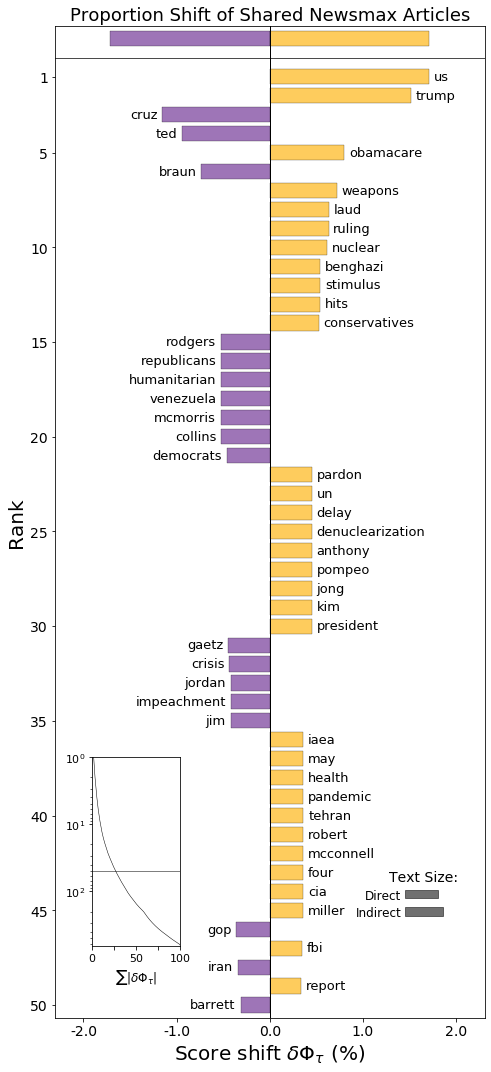

In [50]:
get_shifterator_graph('Proportion Shift of Shared Newsmax Articles', 'Direct', 'Indirect', newsmax_tokens_direct_url, newsmax_tokens_indirect_url)

- `newsmax_tokens_direct_url`
- `newsmax_tokens_indirect_title`

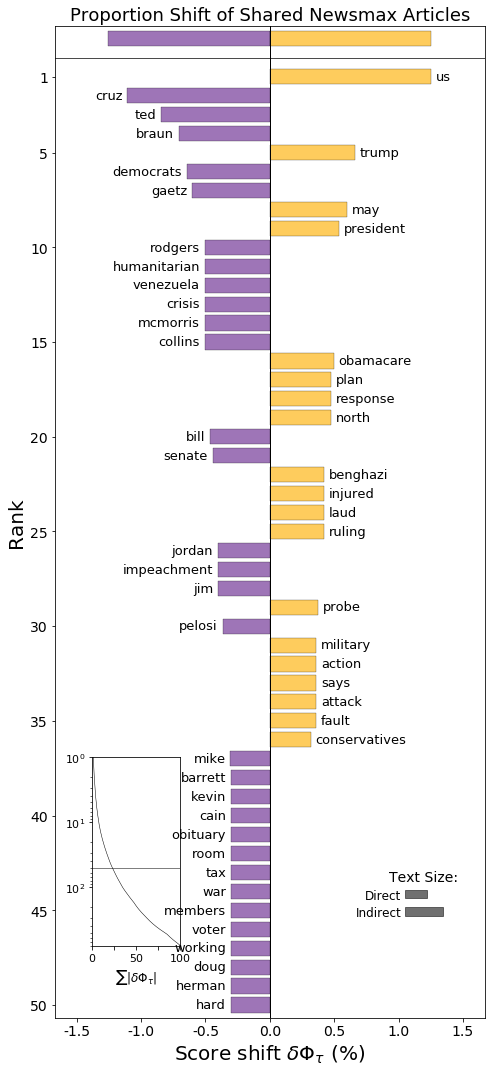

In [51]:
get_shifterator_graph('Proportion Shift of Shared Newsmax Articles', 'Direct', 'Indirect', newsmax_tokens_direct_url, newsmax_tokens_indirect_title)

### Analyze Breitbart: Direct Tokens vs. Indirect Tokens
- `breitbart_tokens_direct_url`
- `breitbart_tokens_indirect_url`
- **Note**: Unlike the Twitter-sourced Breitbart URLs which reliably have keywords in 6th position. the keyword placement varies notably among the Media Cloud-sourced Breitbart URLs. This makes the cleaning function outputs less consistent. May be more useful to compare `direct (URL)` and `indirect (title)`.

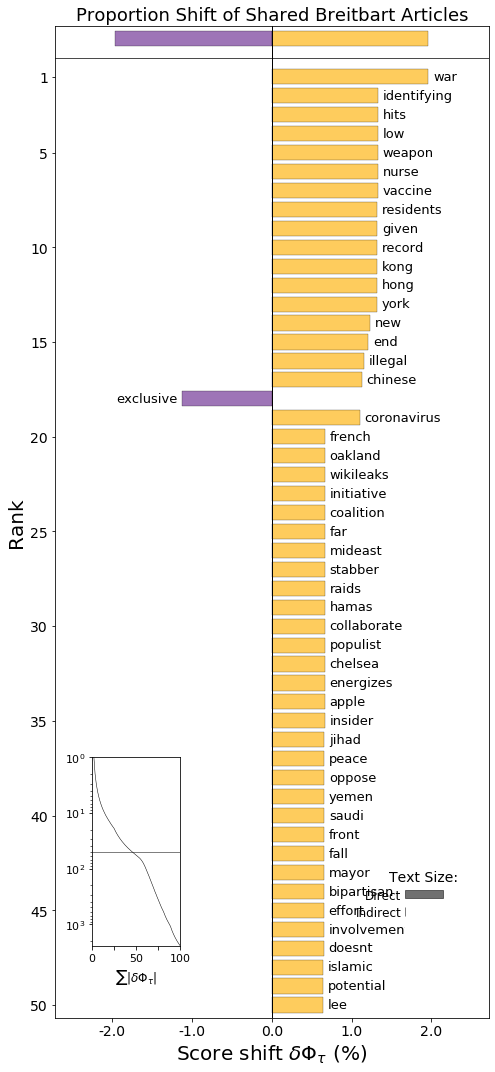

In [52]:
# Don't use: inconsistent URL structure resulted in poor parsing results.
get_shifterator_graph('Proportion Shift of Shared Breitbart Articles', 'Direct', 'Indirect', breitbart_tokens_direct_url, breitbart_tokens_indirect_url)

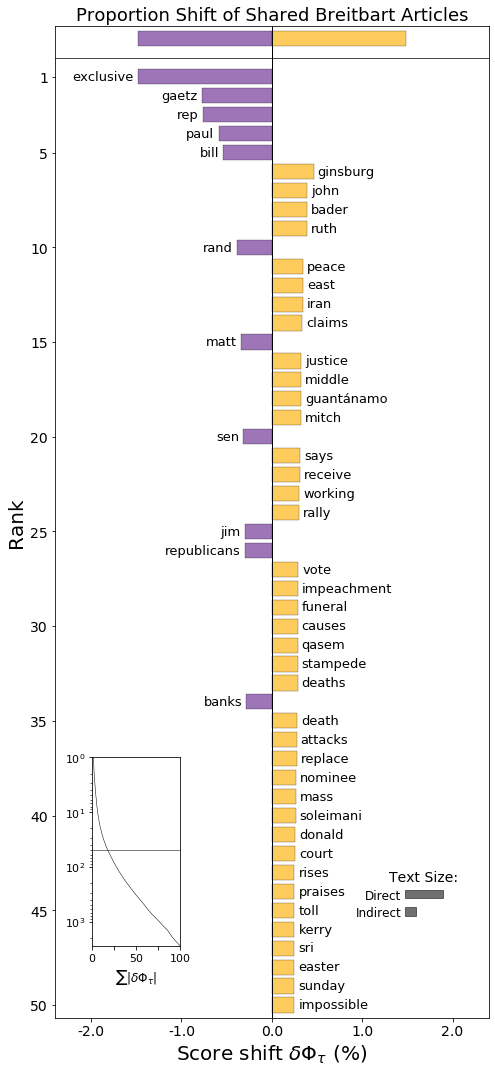

In [53]:
# url_tokens for direct shares vs. title_tokens for indirect shares
get_shifterator_graph('Proportion Shift of Shared Breitbart Articles', 'Direct', 'Indirect', breitbart_tokens_direct_url, breitbart_tokens_indirect_title)

### Analyze Newsmax + Breitbart: Direct Tokens vs. Indirect Tokens
- `newsmax_tokens_direct_url` + `newsmax_tokens_indirect_url`
- `breitbart_tokens_direct_url` + `breitbart_tokens_indirect_url`

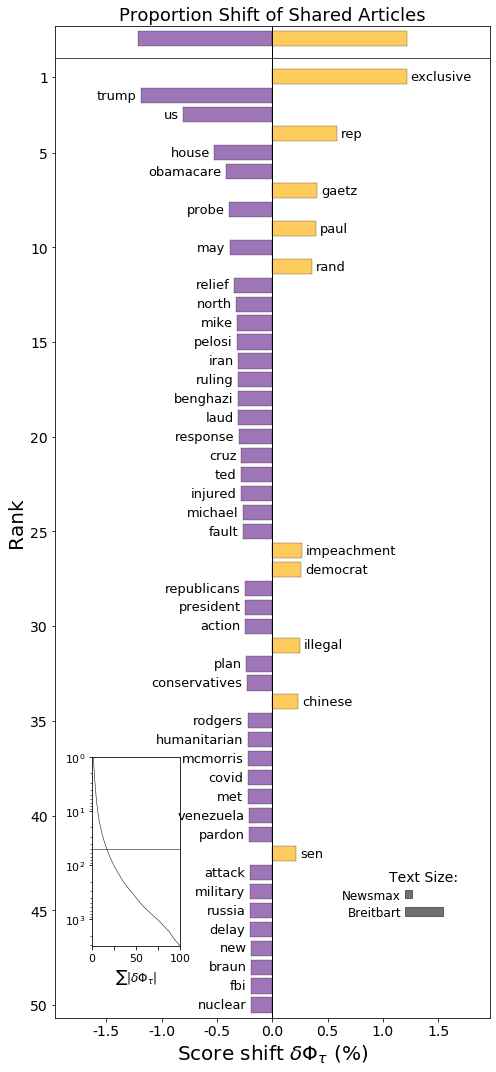

In [54]:
get_shifterator_graph('Proportion Shift of Shared Articles',
                      'Newsmax', 'Breitbart',
                      newsmax_tokens_direct_url + newsmax_tokens_indirect_title,
                      breitbart_tokens_direct_url + breitbart_tokens_indirect_title)